In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np



def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

In [2]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.

    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a
    # hyperparameter.

    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

    def forward_with_intermediate(self, input):
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate


class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)

                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()

                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else:
                x = layer(x)

                if retain_grad:
                    x.retain_grad()

            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [3]:
import random
def lossFun(x,y):
    return x*x +y*y-1
def generate_data(num_samples,fun_num = 0):
    if fun_num == 0: # circle
        # Generate random (x, y) coordinates between -1 and 1
        x = torch.rand(num_samples, 2) * 2 - 1  # Range [-1, 1]
        # Compute the target function: 1 - x^2 - y^2
        y = 1 - x[:, 0] ** 2 - x[:, 1] ** 2
        return x, y.view(-1, 1)
    elif fun_num==1: #star shape
        coordinates = 2 * torch.rand(num_samples, 2) - 1  # Tensor of shape (500, 2) with values in range [-1, 1]

        # Calculate distances for each point
        distances = torch.empty(num_samples)
        for i in range(num_samples):
            x, y = coordinates[i]
            distances[i] = distance_from_star_contour([x.item(), y.item()])
        
        return coordinates, distances
    

In [4]:
import matplotlib.pyplot as plt 
def plotDisctancefunction(eval_fun, N=500):
    x_values = np.linspace(-1.1, 1.1, N)
    y_values = np.linspace(-1.1, 1.1, N)
    X, Y = np.meshgrid(x_values, y_values)
    Z = np.zeros((N,N))
    # Evaluate the function at each point in the grid
    for idxx, xx in enumerate(x_values):
        for idxy,yy in enumerate(y_values):
            #print(yy)
            try:
                crd = torch.tensor([xx, yy], dtype=torch.float32)
                ans = eval_fun(crd)
                Z[idxy, idxx] = ans[0].item()
            except:
                Z[idxy, idxx] = eval_fun([xx,yy])

    #Z = distanceFromContur(X, Y)

    # Create a contour plot
    plt.contourf(X, Y, Z,levels=20)
    plt.colorbar(label='f(x, y)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Scalar-Valued Function f(x, y)')
    plt.grid(True)
    plt.show()

In [13]:
img_siren = Siren(in_features=2, out_features=1, hidden_features=256,hidden_layers=2, outermost_linear=True)
total_steps = 140 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = total_steps/10

optim = torch.optim.Adam(lr=1e-3, params=img_siren.parameters())

model_input, ground_truth = generate_data(100000)

In [14]:
for step in range(total_steps):
    model_output, coords = img_siren(model_input)
    loss = ((model_output - ground_truth)**2).mean()

    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))

    optim.zero_grad()
    loss.backward()
    optim.step()

Step 0, Total loss 0.288695
Step 14, Total loss 0.007218
Step 28, Total loss 0.001451


In [84]:
# Test the trained model on some new data
test_coords = torch.tensor([0, 1], dtype=torch.float32)
predictions = img_siren(test_coords)
#model.test()
print("\nTest Input (x, y):")
print(test_coords)
print("Predicted Output:")
print(predictions)
print("Actual output:")
print(1-test_coords[0] ** 2 - test_coords[1] ** 2 )


Test Input (x, y):
tensor([0., 1.])
Predicted Output:
(tensor([-0.0032], grad_fn=<ViewBackward0>), tensor([0., 1.], requires_grad=True))
Actual output:
tensor(0.)


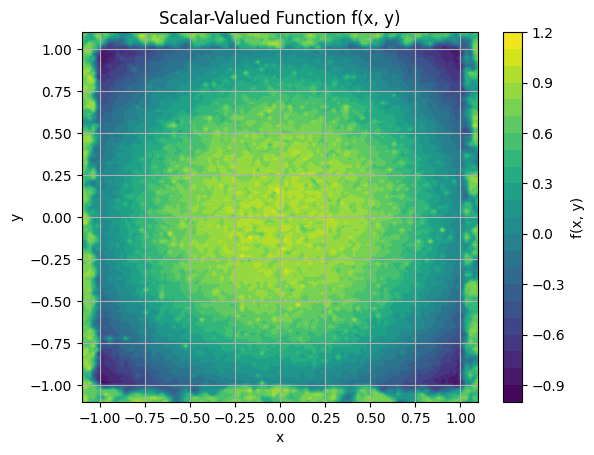

In [12]:
plotDisctancefunction(img_siren,N=100)

In [63]:
import math

def distance_point_to_line(px, py, x1, y1, x2, y2):
    """Calculate the perpendicular distance from point (px, py) to the line segment (x1, y1) -> (x2, y2)."""
    # Line segment length squared
    line_length_sq = (x2 - x1) ** 2 + (y2 - y1) ** 2
    if line_length_sq == 0:  # The segment is a point
        return math.sqrt((px - x1) ** 2 + (py - y1) ** 2)

    # Projection factor
    t = max(0, min(1, ((px - x1) * (x2 - x1) + (py - y1) * (y2 - y1)) / line_length_sq))

    # Projection point on the segment
    proj_x = x1 + t * (x2 - x1)
    proj_y = y1 + t * (y2 - y1)

    # Distance to the projection
    return math.sqrt((px - proj_x) ** 2 + (py - proj_y) ** 2)

def calculate_star_vertices(R, r, n=5):
    """Calculate the vertices of a regular star with n points centered at the origin."""
    vertices = []
    angle_between_points = 2 * math.pi / (2 * n)
    
    for i in range(2 * n):
        if i % 2 == 0:
            radius = R  # Outer point
        else:
            radius = r  # Inner point
        angle = i * angle_between_points
        x = radius * math.cos(angle)
        y = radius * math.sin(angle)
        vertices.append((x, y))
    
    return vertices

def distance_from_star_contour(coord, R=1, r=0.5, n=5):
    """
    Calculate the minimum distance from point (x, y) to the contour of a star shape.
    :param x: x-coordinate of the point
    :param y: y-coordinate of the point
    :param R: Radius of the outer points of the star
    :param r: Radius of the inner points of the star
    :param n: Number of star points (default is 5 for a 5-pointed star)
    :return: Minimum distance from the point to the star contour
    """
    x=coord[0]
    y=coord[1]
    # Get the star vertices
    vertices = calculate_star_vertices(R, r, n)
    
    # Find the minimum distance from the point (x, y) to any edge of the star
    min_distance = float('inf')
    
    for i in range(len(vertices)):
        x1, y1 = vertices[i]
        x2, y2 = vertices[(i + 1) % len(vertices)]
        dist = distance_point_to_line(x, y, x1, y1, x2, y2)
        min_distance = min(min_distance, dist)
    
    return min_distance

# Example usage
x, y = 0.5, 0.5  # Example point
distance = distance_from_star_contour([x, y])
print(f"Distance from point ({x}, {y}) to star contour: {distance}")


Distance from point (0.5, 0.5) to star contour: 0.12413695443332941


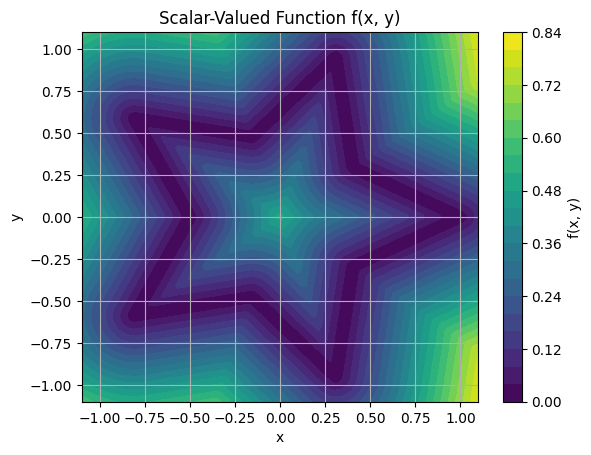

In [77]:
plotDisctancefunction(distance_from_star_contour,N=100)